# Importar librerías

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import xgboost as xgb
import optuna
import shap
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("../data/procesado/data_procesado.csv")
df.head()

,fecha,ticker,precio_cierre,retorno_diario,tasa_bono,volumen
0,2020-10-05 00:00:00,AAPL,113.321625,0.0,0.0078,106243800
1,2020-10-05 00:00:00,AMZN,159.960007,0.0,0.0078,75506000
2,2020-10-05 00:00:00,BA,171.199997,0.0,0.0078,19082100
3,2020-10-05 00:00:00,BAC,21.796659,0.0,0.0078,44396800
4,2020-10-05 00:00:00,BHP,33.512653,0.0,0.0078,1701342


# Volver a Formato Horizontal

En el notebook anterior se trabajó con el DataFrame en formato vertical para hacer más fácil el proceso de consultas en SQL. Sin embargo, para poder trabajar con el portafolio de forma más eficiente en python, es necesario volver a un formato horizontal. Afortunadamente, es un proceso fácil de realizar.

In [3]:
df_retornos_wide = df.pivot(index="fecha", columns="ticker", values="retorno_diario")

# Variables Importantes

Estas variables son necesarias para pasos posteriores.

In [4]:
num_portfolios = 25000

tasa_libre_riesgo = df["tasa_bono"].iloc[-1]

retornos_medios_anual = df_retornos_wide.mean() * 252
matriz_cov_anual = df_retornos_wide.cov() * 252

In [5]:
def calcular_max_drawdown(retornos_serie):
    """Calcula la máxima caída (Max Drawdown) de una serie de retornos."""
    retorno_acumulado = (1 + retornos_serie).cumprod()
    pico_anterior = retorno_acumulado.cummax()
    drawdown = (retorno_acumulado - pico_anterior) / pico_anterior
    return drawdown.min()

print(f"\nEjecutando simulación de Monte Carlo con {num_portfolios} portafolios...")

resultados = []
pesos_portafolios = []
num_activos = len(df_retornos_wide.columns)

for i in range(num_portfolios):
    pesos = np.random.random(num_activos)
    pesos /= np.sum(pesos)
    pesos_portafolios.append(pesos)

    retorno = np.sum(retornos_medios_anual * pesos)
    volatilidad = np.sqrt(np.dot(pesos.T, np.dot(matriz_cov_anual, pesos)))
    
    sharpe = (retorno - tasa_libre_riesgo) / volatilidad
    
    retornos_port_diarios = (df_retornos_wide * pesos).sum(axis=1)
    retornos_negativos_diarios = retornos_port_diarios[retornos_port_diarios < 0]
    volatilidad_negativa = retornos_negativos_diarios.std() * np.sqrt(252)
    sortino = (retorno - tasa_libre_riesgo) / volatilidad_negativa if volatilidad_negativa > 0 else 0
    
    max_drawdown = calcular_max_drawdown(retornos_port_diarios)
    calmar = retorno / abs(max_drawdown) if max_drawdown < 0 else 0
    
    var_95 = np.percentile(retornos_port_diarios, 5)
    
    resultados.append([retorno, volatilidad, sharpe, sortino, calmar, var_95])

df_simulacion = pd.DataFrame(resultados, columns=["retorno", 
                                                  "volatilidad", 
                                                  "sharpe", 
                                                  "sortino", 
                                                  "calmar", 
                                                  "var_95"])
df_pesos = pd.DataFrame(pesos_portafolios, columns=df_retornos_wide.columns)
df_simulacion = pd.concat([df_simulacion, df_pesos], axis=1)

# Identificar portafolios óptimos
max_sortino_port = df_simulacion.loc[df_simulacion["sortino"].idxmax()]
min_vol_port = df_simulacion.loc[df_simulacion["volatilidad"].idxmin()]

print("\n--- Portafolio de Mínima Volatilidad ---")
print(min_vol_port.tail(num_activos).sort_values(ascending=False).head())
print(f"\n--- Portafolio de Máximo Ratio de Sortino ---")
print(max_sortino_port.tail(num_activos).sort_values(ascending=False).head())




Ejecutando simulación de Monte Carlo con 25000 portafolios...

--- Portafolio de Mínima Volatilidad ---
JNJ    0.099451
PFE    0.098676
UNH    0.096324
XOM    0.087185
MCD    0.085369
Name: 1906, dtype: float64

--- Portafolio de Máximo Ratio de Sortino ---
JPM     0.126530
XOM     0.104216
NVDA    0.103895
WMT     0.088494
CAT     0.085301
Name: 537, dtype: float64


# Visualización de Frontera Eficiente
Ahora haremos un gráfico dinámico a través de plotly, sin embargo, la línea de código necesaria para guardar la imagen está desactivada debido a problemas técnicos del navegador web en el que trabajo. Dicho esto, si se trabaja con el navegador Google Chrome solo hay que borrar el símbolo "#". De otro modo, hay que descargar la imagen de forma manual.

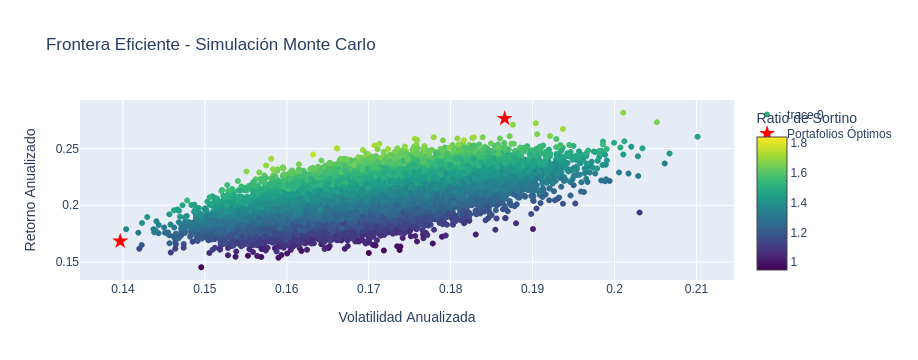

In [6]:
fig = go.Figure()

# Añadir todos los portafolios simulados
fig.add_trace(go.Scatter(
    x=df_simulacion["volatilidad"],
    y=df_simulacion["retorno"],
    mode="markers",
    marker=dict(
        color=df_simulacion["sortino"],
        showscale=True,
        colorscale="Viridis",
        colorbar=dict(title="Ratio de Sortino")
    ),
    text=[f"Sortino: {s:.2f}" for s in df_simulacion["sortino"]] # Tooltip
))

# Marcar los portafolios óptimos
fig.add_trace(go.Scatter(
    x=[min_vol_port["volatilidad"], max_sortino_port["volatilidad"]],
    y=[min_vol_port["retorno"], max_sortino_port["retorno"]],
    mode="markers",
    marker=dict(color="red", size=12, symbol="star"),
    name="Portafolios Óptimos"
))

fig.update_layout(
    title="Frontera Eficiente - Simulación Monte Carlo",
    xaxis_title="Volatilidad Anualizada",
    yaxis_title="Retorno Anualizado",
    showlegend=True
)
project_root = Path.cwd()
figures_path = project_root / "fig"
image_filename = "frontera_eficiente.png"
image_path = figures_path / image_filename
# fig.write_image(image_path)

fig.show()



# Preproceso de Datos

## Feature Engineering
Para poder predecir la volatilidad de los próximos 21 días, vamos a trabajar con la volatilidad pasada, por lo tanto, es necesario crear tres columnas nuevas que cubren:
- Volatilidad pasada
- Retorno pasado
- Volumen pasado

De los 21 días anteriores a la fecha.

In [7]:
# Usaremos 'SPY' como proxy del mercado
df_spy = df[df["ticker"] == "SPY"].set_index("fecha").sort_index()

df_ml = pd.DataFrame(index=df_spy.index)
df_ml["volatilidad_pasada_21d"] = df_spy["retorno_diario"].rolling(window=21).std().shift(1)
df_ml["retorno_pasado_21d"] = df_spy["retorno_diario"].rolling(window=21).mean().shift(1)
df_ml["volumen_pasado_21d"] = df_spy["volumen"].rolling(window=21).mean().shift(1)

## Creación del objetivo
Ahora, vamos a crear la variable objetivo "volatilidad futura".

In [8]:
df_ml["volatilidad_futura_21d"] = df_spy["retorno_diario"].rolling(window=21).std().shift(-21)

df_ml = df_ml.dropna()

## Separación de datos
Ya que hemos creado las variables para la predicción y la variable objetivo, es hora de separarlas para poder empezar el entrenamiento.

In [9]:
X = df_ml.drop("volatilidad_futura_21d", axis=1)
y = df_ml["volatilidad_futura_21d"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Optimización de Parámetros

In [10]:
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "n_jobs": -1,
        "tree_method": "hist",
        "verbosity": 0,
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0)
    }
    model = xgb.XGBRegressor(**params)
    
    score = cross_val_score(model, X_train, y_train, cv=3, scoring="neg_mean_squared_error")
    return np.mean(score)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=300)

print(f"\nMejor puntaje (neg_mse): {study.best_value:.4f}")
print(f"Mejores parámetros: {study.best_params}")



Mejor puntaje (neg_mse): -0.0000
Mejores parámetros: {'max_depth': 5, 'learning_rate': 0.035390242211198485, 'n_estimators': 100, 'subsample': 0.8546738418958028, 'colsample_bytree': 0.8310129795026039}


# Evaluación

In [11]:
final_ml_model = xgb.XGBRegressor(**study.best_params)
final_ml_model.fit(X_train, y_train)

print("\n--- Evaluando el modelo de ML final ---")
predictions = final_ml_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE en el conjunto de prueba: {rmse:.6f}")


--- Evaluando el modelo de ML final ---
RMSE en el conjunto de prueba: 0.006237


# Explicabilidad

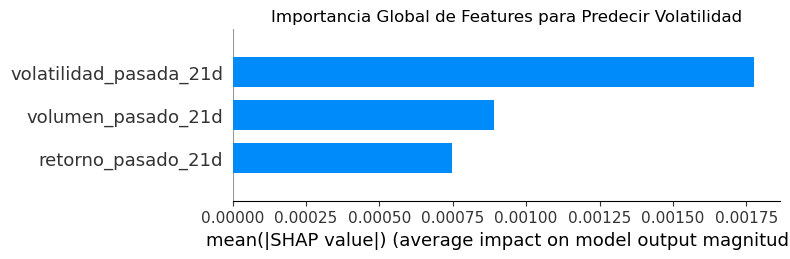

In [12]:
explainer = shap.TreeExplainer(final_ml_model)
shap_values = explainer(X_test)


project_root = Path.cwd().parent
figures_path = project_root / "fig"
image_path = figures_path / "shap_importancia.png"


shap.summary_plot(shap_values, X_test, plot_type='bar', show=False)
plt.title("Importancia Global de Features para Predecir Volatilidad")
plt.tight_layout()
plt.savefig(
    image_path,
    dpi=300,             
    bbox_inches="tight" 
)
plt.show()



# Aplicación y Conclusión

In [13]:
ultimas_features = X.tail(1)
volatilidad_predicha = final_ml_model.predict(ultimas_features)[0]
volatilidad_media_historica = y.mean()

print("\n--- Recomendación Estratégica Final ---")
print(f"La volatilidad predicha para el próximo mes es: {volatilidad_predicha:.6f}")
print(f"La volatilidad media histórica es: {volatilidad_media_historica:.6f}")

if volatilidad_predicha > volatilidad_media_historica:
    print("\nSe predice un período de ALTA VOLATILIDAD.")
    print("Recomendación: Adoptar una postura defensiva. Considerar el portafolio de MÍNIMA VOLATILIDAD:")
    print(min_vol_port.tail(num_activos).sort_values(ascending=False).head())
else:
    print("\nSe predice un período de BAJA A MODERADA VOLATILIDAD.")
    print("Recomendación: Adoptar una postura orientada al retorno. Considerar el portafolio de MÁXIMO RATIO DE SORTINO:")
    print(max_sortino_port.tail(num_activos).sort_values(ascending=False).head())



--- Recomendación Estratégica Final ---
La volatilidad predicha para el próximo mes es: 0.007351
La volatilidad media histórica es: 0.009816

Se predice un período de BAJA A MODERADA VOLATILIDAD.
Recomendación: Adoptar una postura orientada al retorno. Considerar el portafolio de MÁXIMO RATIO DE SORTINO:
JPM     0.126530
XOM     0.104216
NVDA    0.103895
WMT     0.088494
CAT     0.085301
Name: 537, dtype: float64


# Guardar Modelo
Guardaremos el modelo en un pickle para así poder trabajar con el modelo sin necesidad de volver a entrenarlo.

In [14]:
project_root = Path.cwd().parent

carp_pkl = project_root / "pkl"

carp_pkl.mkdir(exist_ok=True, parents = True)
mejor_modelo_path = carp_pkl / "mejor_modelo.pkl"
mejores_params_path = carp_pkl / "mejores_parámetros.pkl"

with open(mejor_modelo_path, 'wb') as f:
        pickle.dump(final_ml_model, f)

with open(mejores_params_path, 'wb') as f:
        pickle.dump(study.best_params, f)